An `RR-RFF` notebook that
1. evaluates RR-RFF's `inv_quad` and `log_det` bias versus vanilla RFF and Cholesky.
2. similarly compares hyperparameter recovery between the methods

In [1]:
import gpytorch
import math
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from gpytorch.kernels.rr_rff import RR_RFF_Kernel
from rr_utils.dist_of_iterations import ExpDecayDist, OneOverJ, UniformDist

%load_ext autoreload
%autoreload 2

In [2]:
# Andres' funcs
from experiments.experiment_fns import GPRegressionModel, \
        GPRegressionModelRFF, train, set_hypers, \
        randomly_sample_hypers, recover_cholesky, \
        recover_rff, print_initial_hypers, plot_results # add Tracker

In [3]:
def get_hypers(model):
    hypers = {}
    hypers["noise_scale"] = model.likelihood.noise_covar.noise.item()
    hypers["ls"] = model.covar_module.base_kernel.lengthscale.item()
    hypers["output_scale"] = model.covar_module.outputscale.item()
    return hypers

In [4]:
def build_RFF_model(hypers, num_rff_samples, train_ds):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    RFF_model = GPRegressionModelRFF(*train_ds, likelihood, num_rff_samples)
    # fix hypers (assuming they were pre-optimized in a Cholesky model)
    set_hypers(RFF_model, hypers["noise_scale"], hypers["ls"],
               hypers["output_scale"])
    return RFF_model

In [5]:
class GPRegressionModel_RR_RFF(gpytorch.models.ExactGP):
    '''a model that uses the RR_RFF_Kernel as the base_kernel,
    recieves a truncation distribution (dist_obj), and at every forward call
    samples an integer from dist_obj and uses it to compute cov mat'''
    def __init__(self, train_x, train_y, likelihood, dist_obj, single_sample):
        super().__init__(train_x, train_y, likelihood)
        self.dist_obj = dist_obj
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            RR_RFF_Kernel(single_sample=single_sample,
                          min_val=self.dist_obj.min))

    def single_sample_estimator(self, terms):
        '''for any two terms, compute their difference and weigh it by 1/p(J)'''
        J = torch.clone(self.covar_module.base_kernel.num_samples)
        # ToDo: check whether we're summing up to k or up to k-1.
        # now trying a sum up to k-1
        # ToDo: account for min_val == 1. right now not supported.
        if self.covar_module.base_kernel.min_val==1:
            print('min_val=1 currently not supported by single_sample_estimator()')
        base_terms = terms[:self.covar_module.base_kernel.min_val-1]
        shifted_base_terms = torch.cat([torch.zeros(1), \
                                       base_terms[:-1]])
        base_deltas = base_terms - shifted_base_terms
        final_delta = terms[-1] - terms[-2]
        ss_weight = 1. / self.dist_obj.prob(J)
        ss_estimator = ss_weight * final_delta  + base_deltas.sum()
        return ss_estimator

    def RR_estimator(self, J_terms):
        '''for any J terms, weigh them by weight diffs to get the RR estimator'''
        J = torch.clone(self.covar_module.base_kernel.num_samples)
        # compute {c1-c2, c2-c3, ... , cJ)
        rr_weight_diffs = self.dist_obj.compute_weight_diffs(J)
        # compute weighted sum
        rr_estimator = rr_weight_diffs.dot(J_terms)
        return rr_estimator

    def RT_estimator(self, input_terms):
        '''method that either runs SS or RR estimation based on
        the single_sample flag inside our base kernel.'''
        if self.covar_module.base_kernel.single_sample:
            #assert input_terms.numel() == 2 # ToDo: modify assertion with unique
            return self.single_sample_estimator(input_terms)
        else:
            assert input_terms.numel(
            ) == self.covar_module.base_kernel.num_samples
            return self.RR_estimator(input_terms)

    def forward(self, x):
        mean_x = self.mean_module(x)
        # covar ops: Russian Roulette
        # sample
        J = self.dist_obj.sample()
        # redefine num_samples for forward pass
        self.covar_module.base_kernel.num_samples = torch.clone(J)
        covar_x = self.covar_module(x)  # forward pass
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
def build_RR_RFF_model(train_ds, dist_obj, single_sample, hypers):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel_RR_RFF(train_ds[0],
                                     train_ds[1],
                                     likelihood,
                                     dist_obj,
                                    single_sample)
    if hypers is not None:
        # if you're given specific params, use them. otherwise auto init.
        set_hypers(model, 
                   hypers["noise_scale"], 
                   hypers["ls"], 
                   hypers["output_scale"])
    return model

In [7]:
def visualize_distrib(RRDist_obj, title):
    # ToDo: add 1/(1-CDF(J-1))
    xvals = np.arange(1, len(RRDist_obj.probs)+1)
    plt.plot(xvals, 
         RRDist_obj.probs.numpy(), '--o', label = 'PMF(J)')
    plt.plot(xvals, 
         RRDist_obj.cdf_full.numpy(), 
         '--o',
         label = "CDF(J)")
    plt.xlabel('J')
    plt.title(title)
    #plt.xticks(xvals)
    plt.legend();

### create training data

In [8]:
# classic simulated
# train_x = torch.linspace(0, 1, 200)
# train_y = torch.sin(train_x * (5 * math.pi)) * train_x + torch.randn_like(train_x) * 0.1
# train_ds = (train_x, train_y)
# test_x = torch.linspace(-1, 2, 151)

# UCI data
from experiments.load_data import load_uci_data
# train_n = 100
train_n = 1000
train_x, train_y, *_ = load_uci_data('./datasets', 'pol')
train_x, train_y = train_x[:train_n, :], train_y[:train_n]
train_ds = (train_x, train_y)

In [9]:
def train(model, likelihood, name="", total_iters=500):
    train_x, train_y = model.train_inputs[0], model.train_targets

    # Optimize only lengthscale
    # optimizer = torch.optim.Adam(model.covar_module.base_kernel.parameters(), lr=0.05)

    # Optimize all the three classical params
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    model.train()
    iterator = tqdm(range(total_iters), desc=f"{name} Training")
    output = model(train_x)
    loss = -mll(output, train_y)

    for _ in iterator:
        optimizer.zero_grad()
        output = model(train_x)
        
        loss = -mll(output, train_y)
        
        # ToDo: modify for single_sample estimator. Modify also for RR estimator to use the model methods.
        if hasattr(model, "dist_obj"):
            J = torch.clone(model.covar_module.base_kernel.num_samples)
            # compute {c1-c2, c2-c3, ... , cJ)
            rr_weight_diffs = model.dist_obj.compute_weight_diffs(J)
            # compute weighted sum
            loss = rr_weight_diffs.dot(loss)
            
        loss.backward()
        optimizer.step()
        # inv_quad, logdet = mll.parts(output, train_y) # andres' modified implementation
        iterator.set_postfix(
            loss=loss.item(), ls=model.covar_module.base_kernel.lengthscale.item(),
            os=model.covar_module.outputscale.item(), noise=likelihood.noise.item())

        # Reset RFF weights
        if hasattr(model.covar_module.base_kernel, "randn_weights"):
            model.covar_module.base_kernel.randn_weights.normal_()

    return mll

In [10]:
def compute_logdet_invquad(likelihood, model, train_ds):
    '''for rr-rff: log_det.numel() == num_samples, pre rr-weighted sum
    for rff and exact: log_det.numel() == 1'''
    with gpytorch.settings.debug(False):  # necessary for rr-rff
        with torch.no_grad():
            with gpytorch.settings.prior_mode(True):
                out = likelihood(model(train_ds[0]))
                log_det = out.covariance_matrix.logdet()
                inv_quad = out.lazy_covariance_matrix.inv_quad(train_ds[1])

    return log_det, inv_quad


# # test for rr-rff assuming some likelihood, model, train_ds
# log_det_test, inv_quad_test = compute_logdet_invquad(likelihood, model,
#                                                      train_ds)
# assert log_det_test.numel() == model.covar_module.base_kernel.num_samples

In [11]:
def evaluate_RT_rff(likelihood, model, exact_backup_model, train_ds):
    '''provides an rr estimate of logdet and invquad; also tracks Js.
    results should be compared to an RFF estimator with num_samples = torch.mean(J)'''
    log_det, inv_quad = compute_logdet_invquad(likelihood, model,
                                                     train_ds)
    J = torch.clone(model.covar_module.base_kernel.num_samples)
    if model.covar_module.base_kernel.single_sample: # terms include just the difference between J and J-1 terms
        #assert log_det.numel() == 2
        #assert inv_quad.numel() == 2
        a = str('correct this')
    else: # full RR
        assert log_det.numel() == J
        assert inv_quad.numel() == J

    if J == model.dist_obj.max:
    # if J == 1000:
        # modify the last entry of logdet and invquad to the exact sol'n
        log_det_exact, inv_quad_exact = compute_logdet_invquad(
            likelihood, exact_backup_model, train_ds)
        assert log_det_exact.numel() == 1
        assert inv_quad_exact.numel() == 1
        # overwrite last entries
        log_det[-1] = log_det_exact
        inv_quad[-1] = inv_quad_exact
    # RT_estimator is either single sample or russian roulette, depending on single_sample flag in base kernel
    debiased_log_det = model.RT_estimator(log_det)
    debiased_inv_quad = model.RT_estimator(inv_quad)
    
    return J, debiased_log_det, debiased_inv_quad

In [12]:
# old, works
# def evaluate_rr_rff(likelihood, model, exact_backup_model, train_ds):
#     '''provides an rr estimate of logdet and invquad; also tracks Js.
#     results should be compared to an RFF estimator with num_samples = torch.mean(J)'''
#     log_det_rr, inv_quad_rr = compute_logdet_invquad(likelihood, model, train_ds)
#     J = torch.clone(model.covar_module.base_kernel.num_samples)
#     assert log_det_rr.numel() == J
#     assert inv_quad_rr.numel() == J

#     if J == model.dist_obj.max:
#         # modify the last entry of logdet and invquad to the exact sol'n
#         log_det_exact, inv_quad_exact = compute_logdet_invquad(
#             likelihood, exact_backup_model, train_ds)
#         assert log_det_exact.numel() == 1
#         assert inv_quad_exact.numel() == 1
#         # overwrite last entries
#         log_det_rr[-1] = log_det_exact
#         inv_quad_rr[-1] = inv_quad_exact

#     # compute {c1-c2, c2-c3, ... , cJ)
#     rr_weight_diffs = model.dist_obj.compute_weight_diffs(J)
#     # compute weighted sums
#     debiased_log_det = rr_weight_diffs.dot(log_det_rr)
#     debiased_inv_quad = rr_weight_diffs.dot(inv_quad_rr)
#     return J, debiased_log_det, debiased_inv_quad

In [13]:
def run_rff_rounds(num_rr_rounds, likelihood, model, train_ds):
    '''model is assumed to have the right number of samples'''
    res_dict = {}
    res_dict["J"] = torch.zeros(num_rr_rounds,
                                dtype=train_ds[0].dtype,
                                device=train_ds[0].device)
    res_dict["logdet"] = torch.zeros(num_rr_rounds,
                                     dtype=train_ds[0].dtype,
                                     device=train_ds[0].device)
    res_dict["invquad"] = torch.zeros(num_rr_rounds,
                                      dtype=train_ds[0].dtype,
                                      device=train_ds[0].device)

    for i in range(num_rr_rounds):
        res_dict["logdet"][i], res_dict["invquad"][i] = \
        compute_logdet_invquad(likelihood, model, train_ds)

        res_dict["J"][i] = model.covar_module.base_kernel.num_samples

        # take a new sample of the RFF weights
        if hasattr(model.covar_module.base_kernel, "randn_weights"):
            model.covar_module.base_kernel.randn_weights.normal_()

    return res_dict

In [14]:
def run_rr_rounds(num_rr_rounds, likelihood, model, exact_backup_model,
                  train_ds):
    '''computes RR estimators num_rr_rounds times, doing so for logdet and invquad'''
    res_dict = {}
    res_dict["J"] = torch.zeros(num_rr_rounds,
                                dtype=train_ds[0].dtype,
                                device=train_ds[0].device)
    res_dict["logdet"] = torch.zeros(num_rr_rounds,
                                     dtype=train_ds[0].dtype,
                                     device=train_ds[0].device)
    res_dict["invquad"] = torch.zeros(num_rr_rounds,
                                      dtype=train_ds[0].dtype,
                                      device=train_ds[0].device)

    for i in range(num_rr_rounds):
        # was previously evalute_rr_rff
        res_dict["J"][i], res_dict["logdet"][i], res_dict["invquad"][i] = \
        evaluate_RT_rff(likelihood, model, exact_backup_model, train_ds)

    return res_dict


# # test (assuming all instances were initialized, maybe remove)
# test_rr_model = build_RR_RFF_model(train_ds, exp_dist, hypers)
# res_dict_test = run_rr_rounds(3, likelihood, test_rr_model, exact_model, train_ds)

# build and optimize an exact model
## loop over truncation dists
### ->loop over rr rounds to get rr-rff estimators
### ->loop over rff rounds to get rff estimators

# build and optimize and exact model

In [15]:
# build
likelihood = gpytorch.likelihoods.GaussianLikelihood()
exact_model = GPRegressionModel(*train_ds, likelihood)
print_initial_hypers(exact_model)

Pre training: noise scale  0.6932 | lengthscale 0.6931 | output scale 0.6931


In [16]:
# train
total_iters = 500
with gpytorch.settings.max_cholesky_size(int(1.e7)):
    mll = train(exact_model,
                likelihood,
                name="Cholesky",
                total_iters=total_iters)

Cholesky Training:   0%|          | 0/500 [00:00<?, ?it/s]/home/ubu/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
Cholesky Training: 100%|██████████| 500/500 [01:08<00:00,  7.25it/s, loss=0.409, ls=0.367, noise=0.018, os=0.38]  


In [17]:
# exact model logdet and invquad
log_det_exact, inv_quad_exact = compute_logdet_invquad(likelihood, exact_model, train_ds)
log_det_exact = log_det_exact.cpu()
inv_quad_exact = inv_quad_exact.cpu()

/home/ubu/gpytorch/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


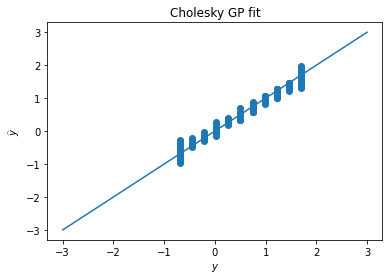

In [18]:
# eval fit on training data
exact_model.eval()
pred = likelihood(exact_model(train_x))
plt.scatter(train_y.cpu(), pred.mean.detach().cpu().numpy())
plt.xlabel(r'$y$')
plt.ylabel(r'$\widehat{y}$')
plt.title('Cholesky GP fit')
plt.plot([-3,3], [-3,3])

In [19]:
# extract the optimized hypers to re-use in RFF and RR-RFF
hypers = get_hypers(exact_model)
print(hypers)

{'noise_scale': 0.01797483116388321, 'ls': 0.36673200130462646, 'output_scale': 0.3797934055328369}


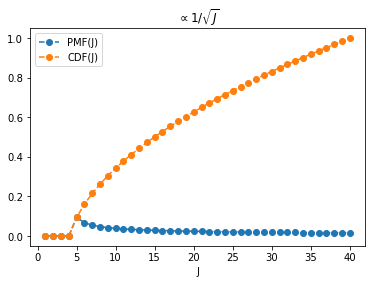

In [20]:
#visualize_distrib(OneOverJ(min=5, max =40, do_sqrt=True),'one_over_J')
dist = OneOverJ(min=5, max =40, do_sqrt=True)
visualize_distrib(dist,r'$\propto 1/\sqrt{J}$')
#print(dist.probs)

In [21]:
# likelihood = gpytorch.likelihoods.GaussianLikelihood()

### loop over `dist_obj`'s 
and compare values for the different methods.

In [22]:
'''We use a one/J distribution for a first pass, looping over range of vals'''
num_rr_rounds = 2000 # 2000 worked well
min_val = torch.linspace(10, 40, 4, dtype = torch.int) # assuming max of 50 for now
max_val = len(train_x) // 2
#temps = torch.logspace(-5, -1, 5) # was (-3,-1, 3)
res_list_rr = []
res_list_rff = []
num_rff_samples = np.zeros_like(min_val)
with torch.no_grad():
    for i in range(len(min_val)):  # ToDo: decide which variable to loop on
        # redefine J distribution
        # 1/J or 1/sqrt(J)
        J_dist = OneOverJ(min=min_val[i], max=max_val, do_sqrt = True)
        # uniform
        #J_dist = UniformDist(min=int(min_val[i]), max=int(max_val))
        # build RR model with trained Cholesky params
        rr_model = build_RR_RFF_model(train_ds=train_ds,
                                      dist_obj=J_dist,
                                      single_sample=True,
                                      hypers=hypers)
        res_list_rr.append(
            run_rr_rounds(num_rr_rounds, likelihood, rr_model, exact_model,
                          train_ds))
        # average number of samples
        num_rff_samples[i] = np.ceil(
            torch.mean(res_list_rr[i]['J']).cpu().numpy())
        rff_model = build_RFF_model(hypers, int(num_rff_samples[i]), train_ds)
        res_list_rff.append(
            run_rff_rounds(num_rr_rounds, likelihood, rff_model, train_ds))

initializing RR RFF class
initializing RR RFF class
initializing RR RFF class
initializing RR RFF class


In [23]:
def print_hypers(model):
    print(f"Outputscale: {model.covar_module.outputscale.item()}")
    print(f"Lengthscale: {model.covar_module.base_kernel.lengthscale.item()}")
    print(f"Noise: {model.likelihood.noise.item()}")

    
print("RR Model")
print_hypers(rr_model)
print("\nExact model:")
print_hypers(exact_model)
# for name, param in rr_model.named_parameters():
#     print(name, param.item())

RR Model
Outputscale: 0.3797934055328369
Lengthscale: 0.36673200130462646
Noise: 0.01797483116388321

Exact model:
Outputscale: 0.3797934055328369
Lengthscale: 0.36673200130462646
Noise: 0.01797483116388321


In [24]:
# ToDo: move pickle utils to utils
import pickle
def save_object(obj, filename):
    with open(filename, "wb") as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def load_object(filename):
    with open(filename, "rb") as input:  # note rb and not wb
        return pickle.load(input)

In [25]:
res_dict = {}
res_dict["rr"] = res_list_rr
res_dict["rff"] = res_list_rff
res_dict["num_samples"] = num_rff_samples
save_object(res_dict, 'results_initial_single_sample_one_over_j')
#test_load = load_object('results_initial_one_over_j')
#test_load

In [26]:
# exact model logdet and invquad
# log_det_exact, inv_quad_exact = compute_logdet_invquad(likelihood, exact_model, train_ds)
# log_det_exact = log_det_exact.cpu()
# inv_quad_exact = inv_quad_exact.cpu()

In [27]:
order = num_rff_samples.argsort()

mean_rff_log_det = np.zeros(len(res_list_rff))
std_rff_log_det = np.zeros(len(res_list_rff))
mean_rr_log_det = np.zeros(len(res_list_rr))
std_rr_log_det = np.zeros(len(res_list_rr))

mean_rff_invquad = np.zeros(len(res_list_rff))
std_rff_invquad = np.zeros(len(res_list_rff))
mean_rr_invquad = np.zeros(len(res_list_rr))
std_rr_invquad = np.zeros(len(res_list_rr))


for i in range(len(res_list_rff)):
    mean_rff_log_det[i] = np.mean(res_list_rff[order[i]]['logdet'].cpu().numpy())
    std_rff_log_det[i] = np.std(res_list_rff[order[i]]['logdet'].cpu().numpy())
    mean_rr_log_det[i] = np.mean(res_list_rr[order[i]]['logdet'].cpu().numpy())
    std_rr_log_det[i] = np.std(res_list_rr[order[i]]['logdet'].cpu().numpy())
    
    mean_rff_invquad[i] = np.mean(res_list_rff[order[i]]['invquad'].cpu().numpy())
    std_rff_invquad[i] = np.std(res_list_rff[order[i]]['invquad'].cpu().numpy())
    mean_rr_invquad[i] = np.mean(res_list_rr[order[i]]['invquad'].cpu().numpy())
    std_rr_invquad[i] = np.std(res_list_rr[order[i]]['invquad'].cpu().numpy())

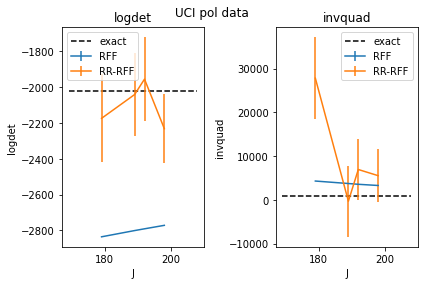

In [28]:
# added a jitter of 5
plt.subplot(121)
plt.hlines(y=log_det_exact,
           xmin=np.min(num_rff_samples)-10,
           xmax=np.max(num_rff_samples)+10,
           linestyle='dashed',
           color='black',
          label='exact')
plt.errorbar(num_rff_samples[order], mean_rff_log_det, std_rff_log_det/np.sqrt(num_rr_rounds), label='RFF')
plt.errorbar(num_rff_samples[order], mean_rr_log_det, std_rr_log_det/np.sqrt(num_rr_rounds), label= 'RR-RFF')
plt.title('logdet')
plt.xlabel('J')
plt.ylabel('logdet')
plt.legend()
plt.subplot(122)
plt.hlines(y=inv_quad_exact,
           xmin=np.min(num_rff_samples[order])-10,
           xmax=np.max(num_rff_samples[order])+10,
           linestyle='dashed',
           color='black',
          label='exact')
plt.errorbar(num_rff_samples[order], mean_rff_invquad, std_rff_invquad/np.sqrt(num_rr_rounds), label='RFF')
plt.errorbar(num_rff_samples[order], mean_rr_invquad, std_rr_invquad/np.sqrt(num_rr_rounds), label= 'RR-RFF')
plt.title('invquad')
plt.xlabel('J')
plt.ylabel('invquad')
plt.suptitle('UCI pol data')
plt.tight_layout()
plt.legend()
plt.savefig('ss-rff-debias-one-over-j.png')

In [29]:
#model_ss.dist_obj.prob(model_ss.dist_obj.min)

In [30]:
# print(mean_rff_log_det)
# print(log_det_exact)
# print(mean_rff_log_det/log_det_exact)

In [31]:
# plt.hlines(y=0, xmin=200, xmax=900, linestyle='dashed', color='black')
# plt.plot(num_rff_samples, np.log(mean_rff_log_det/log_det_exact.numpy()), '-ro')
# plt.plot(num_rff_samples, np.log(mean_rr_log_det/log_det_exact.numpy()), '-bo')
# plt.xlabel('num rff features')

## training an `RR-RFF` model
beware -- it's super slow (it should be J times slower than the equivalent RFF. But we should check whether we have an additional bug.

In [32]:
# # train the rr-rff model
# i = 0 # for test, not really looping over anything
# total_iters = 500
# num_rr_rounds = 200
# min_vals = np.arange(100, 400, 100)
# max_vals = min_vals + int(400)
# temps = 0.00001
# exp_dist = ExpDecayDist(temp=temps, min=min_vals[i], max=max_vals[i])
# rr_model = build_RR_RFF_model(train_ds, exp_dist, None)
# print_initial_hypers(rr_model)
# with gpytorch.settings.debug(False):
# #with gpytorch.settings.lazily_evaluate_kernels(False):
#     #with gpytorch.settings.max_cholesky_size(int(1.e7)):
#     mll = train(rr_model,
#                 likelihood,
#                 name="rr-rff",
#                 total_iters=total_iters)

In [33]:
# # for a single value of expected J, plot the histogram of RR estimators and compares them to RFF Cholsesky
# plt.vlines(x=RFF_log_det.detach().numpy(),
#            ymin=0.,
#            ymax=20.,
#            color='red',
#            label='RFF')
# plt.vlines(x=cholesky_log_det.detach().numpy(),
#            ymin=0.,
#            ymax=20.,
#            color='black',
#            label='Cholesky')
# plt.vlines(x=np.mean(debiased_log_det.detach().numpy()),
#            ymin=0.,
#            ymax=20.,
#            color='blue',
#            linestyle = 'dashed',
#            label='RR mean')
# plt.hist(debiased_log_det.detach().numpy(), label='RR samples')
# plt.xlabel('logdet')
# plt.ylabel('count')
# plt.legend()
# plt.savefig('unbias_test.png')